In [1]:
import numpy as np
from pymonntorch import *
import torch

import matplotlib.pyplot as plt

from models.activity import ActivityRecorder
from models.dendrites import Dendrite
from models.currents import ConstantCurrent, NoisyCurrent, SetCurrent, CurrentSum
from models.encoders import TimeToFirstSpikeEncoder, NumberEncoder, PoissonEncoder, FeedDataset
from models.learnings import STDP
from models.neurons import LIF
from models.synapses import SimpleSynapse, FullyConnectedSynapse, RandomConnectedFixedProbSynapse, \
    RandomConnectedFixedInputSynapse
from models.time_res import TimeResolution
from simulate import Simulation
from utils.images import CustomImage


In [2]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)

encoded_dataset = PoissonEncoder(dataset=[np.concatenate((torch.randperm(50), np.zeros(50))),
                                          np.concatenate((np.zeros(50), 2*torch.randperm(50)))],
                                 duration=50,
                                 )

ng_inp = sim.add_neuron_group(
    tag="ng_inp",
    size=100,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        3: CurrentSum(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        7: FeedDataset(encoded_dataset=encoded_dataset,
                       sleep=15),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_inp_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_inp_event")
    }
)

ng_out = sim.add_neuron_group(
    tag="ng_out",
    size=2,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_event")
    }
)

syn_inp_out = sim.add_synapse_group(
                   tag="syn_inp_out",
                   src=ng_inp,
                   dst=ng_out,
                   behavior={3: FullyConnectedSynapse(j0=60,
                                                      variance=0.5),
                             8: STDP(tau_pre=4,
                                     tau_post=3,
                                     w_max=10,
                                     learning_rate=0.001),
                             9: Recorder(variables=["W"], tag="syn_inp_out_rec"),
                             },
)

sim.simulate(iterations=1000)

/home/amir/Documents/university/Semester 8/Neuroscience/hw3/models/encoders.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  self.dataset = torch.tensor(self.dataset)


Network['Network_1', 'Network'](Neurons: tensor(102)|2 groups, Synapses: tensor(200)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_inp', 'CustomNeuronGroup', 'ng'](100){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)3:CurrentSum()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)7:FeedDataset(encoded_dataset=<models.encoders.PoissonEncoder object at 0x70815045b8d0>,sleep=15,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_event,)}
NeuronGroup['ng_out', 'CustomNeuronGroup', 'ng'](2){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)4:Dendrite()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_out_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


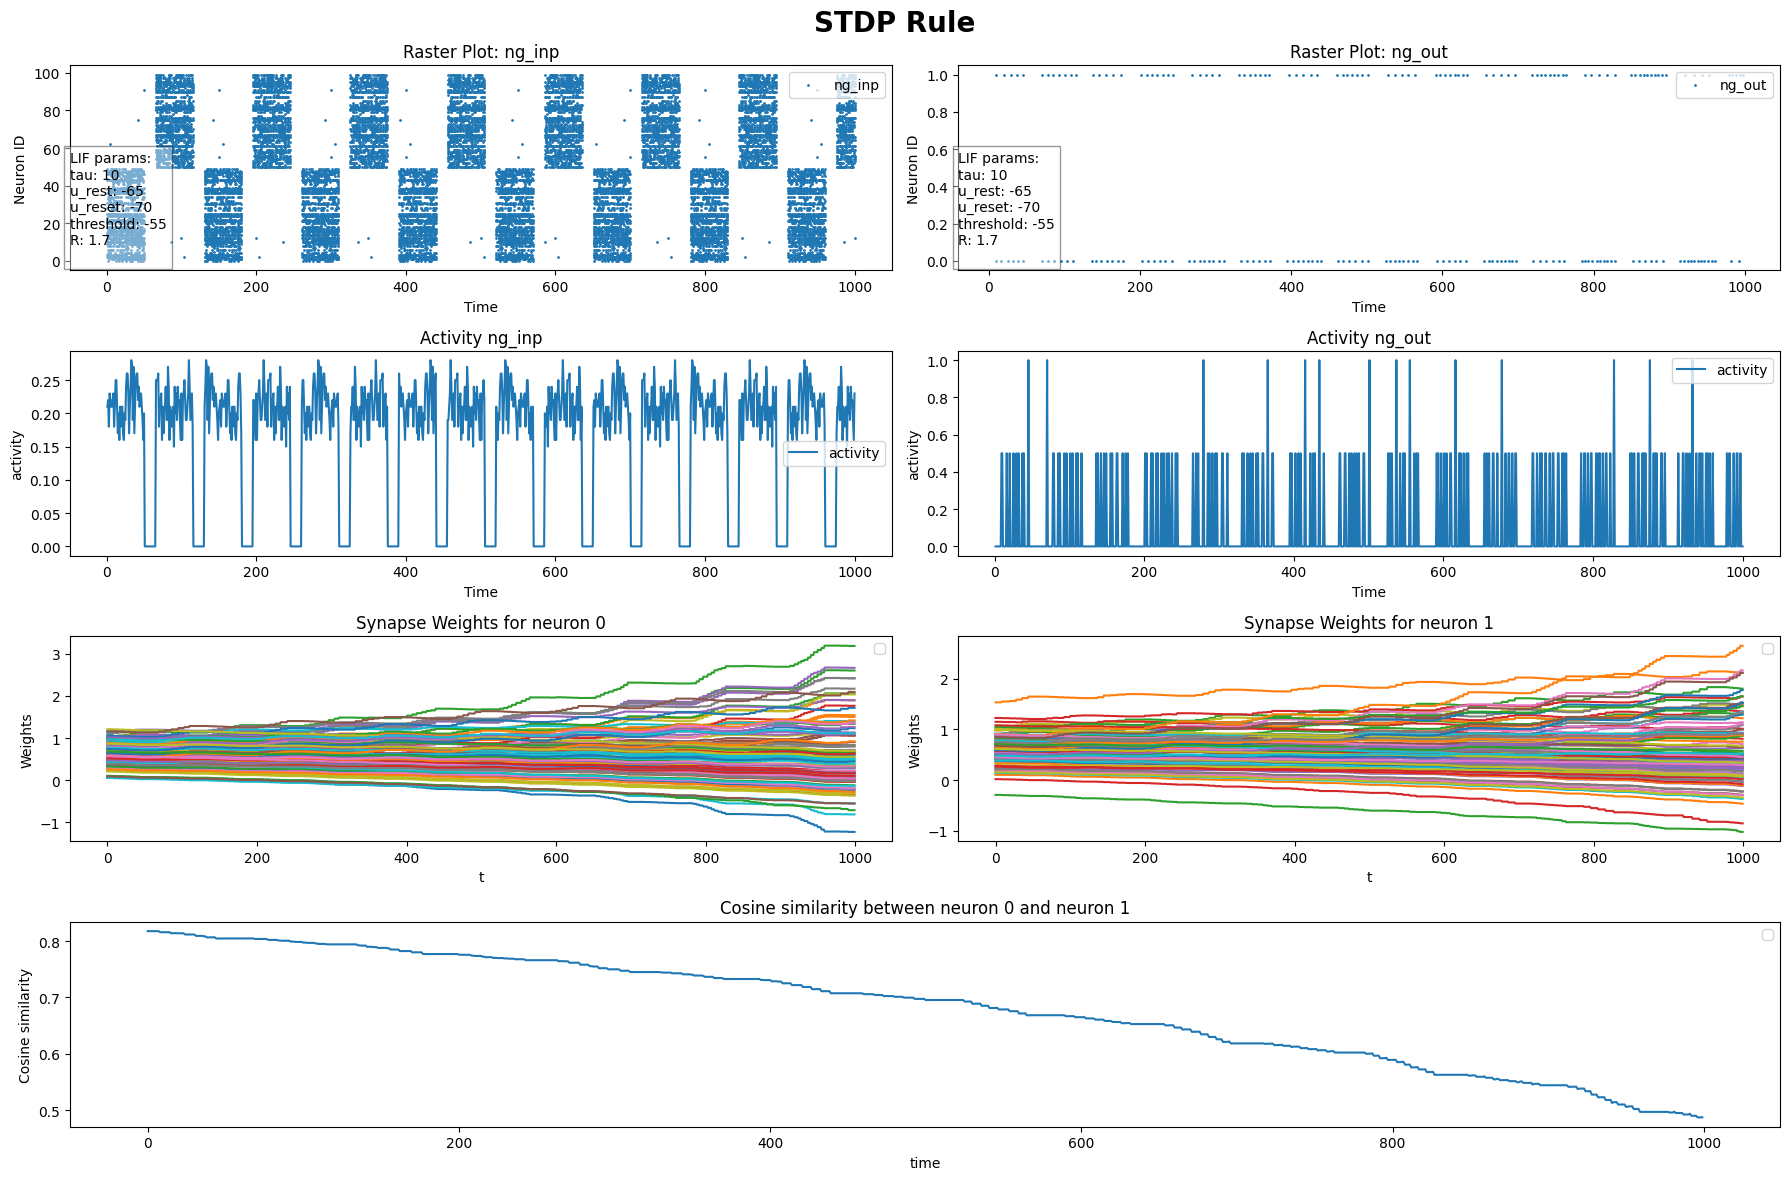

In [4]:
plt.show()
# fig, axs = plt.subplots(2, 1, figsize=(18, 8), sharex=True)
fig = plt.figure(figsize=(18, 12))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 2, 1)  # 3 rows, 1 column, first plot
ng_inp.add_raster_plot(ax1, s=1)
ng_inp.add_neuron_model_params_info(ax1, model_idx=6)

ax2 = fig.add_subplot(4, 2, 3, sharex=ax1)  # 3 rows, 1 column, first plot
ng_inp.add_activity_plot(ax2)

ax3 = fig.add_subplot(4, 2, 2)  # 3 rows, 1 column, first plot
ng_out.add_raster_plot(ax3, s=1)
ng_out.add_neuron_model_params_info(ax3, model_idx=6)

ax4 = fig.add_subplot(4, 2, 4, sharex=ax1)  # 3 rows, 1 column, first plot
ng_out.add_activity_plot(ax4)

ax5 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax5, neuron_id=0)
# ng_out.add_membrane_potential_plot(ax5, model_idx=6)

ax6 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax6, neuron_id=1)

ax7 = fig.add_subplot(4, 1, 4)
syn_inp_out.add_cosine_similarity_plot(ax7,neuron_1=0, neuron_2=1)


fig.suptitle("STDP Rule", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("part1-Simple-ng-without-synapse.pdf")
plt.show()

## Use image as dataset

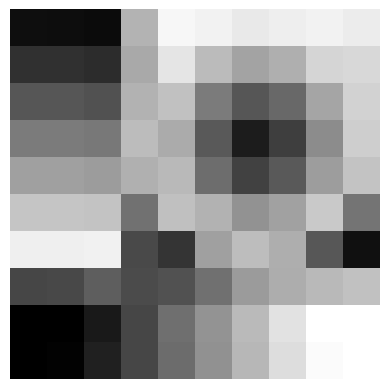

In [5]:
img1 = CustomImage('dataset/slope.tif')
img1.resize_image(10, 10)
img1.img_show()

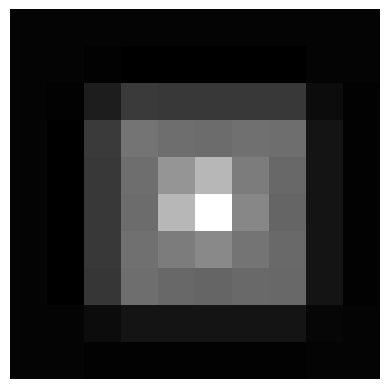

In [6]:
img2 = CustomImage('dataset/squares.tif')
img2.resize_image(10, 10)
img2.img_show()

In [8]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)

encoded_dataset = PoissonEncoder(dataset=[np.concatenate((img1.img2tensor(), np.zeros(70))),
                                          np.concatenate((np.zeros(70), img2.img2tensor()))],
                                 duration=50,
                                 )

ng_inp = sim.add_neuron_group(
    tag="ng_inp",
    size=170,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        3: CurrentSum(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        7: FeedDataset(encoded_dataset=encoded_dataset,
                       sleep=20),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_inp_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_inp_event")
    }
)

ng_out = sim.add_neuron_group(
    tag="ng_out",
    size=2,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_event")
    }
)

syn_inp_out = sim.add_synapse_group(
                   tag="syn_inp_out",
                   src=ng_inp,
                   dst=ng_out,
                   behavior={3: FullyConnectedSynapse(j0=60,
                                                      variance=0.5),
                             8: STDP(tau_pre=4,
                                     tau_post=3,
                                     w_max=10,
                                     learning_rate=0.001),
                             9: Recorder(variables=["W"], tag="syn_inp_out_rec"),
                             },
)

sim.simulate(iterations=1000)

Network['Network_1', 'Network'](Neurons: tensor(172)|2 groups, Synapses: tensor(340)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_inp', 'CustomNeuronGroup', 'ng'](170){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)3:CurrentSum()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)7:FeedDataset(encoded_dataset=<models.encoders.PoissonEncoder object at 0x7081346d3410>,sleep=20,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_event,)}
NeuronGroup['ng_out', 'CustomNeuronGroup', 'ng'](2){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)4:Dendrite()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_out_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


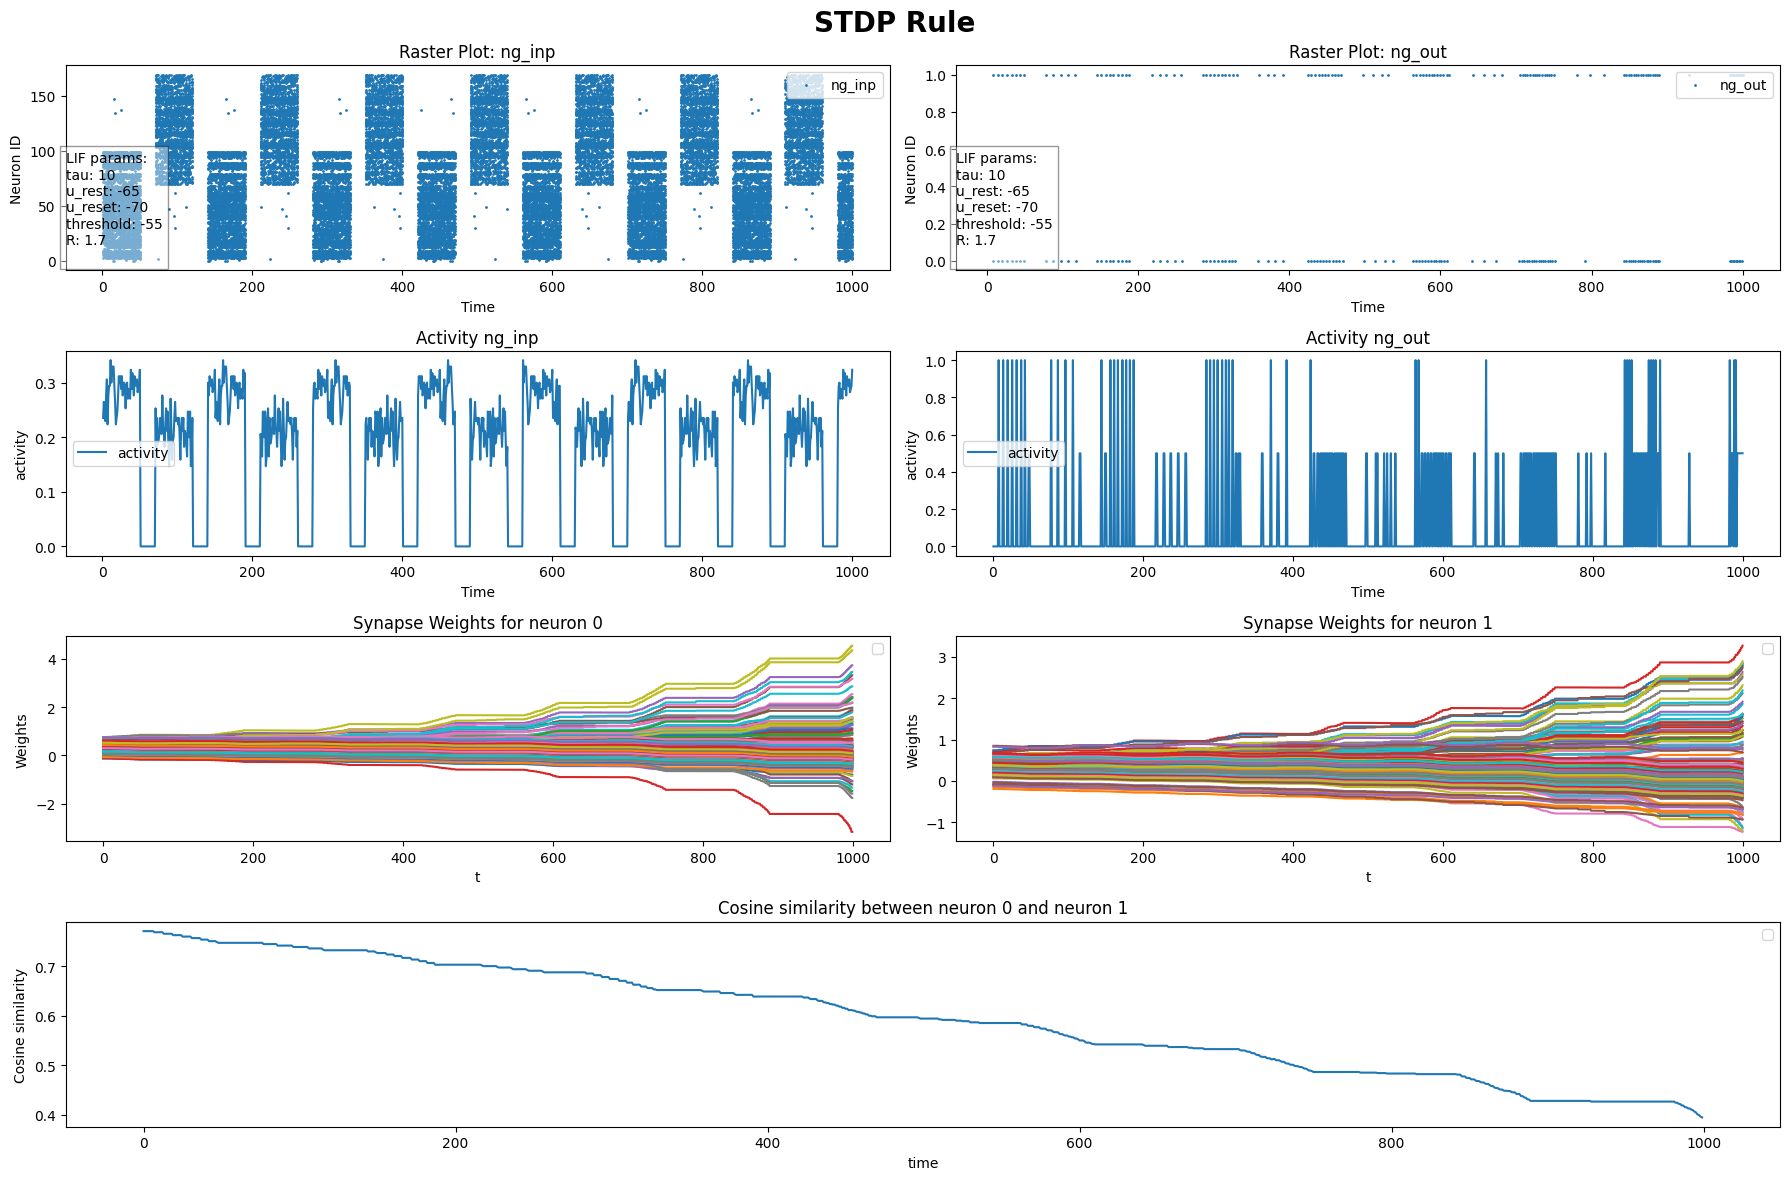

In [9]:
plt.show()
# fig, axs = plt.subplots(2, 1, figsize=(18, 8), sharex=True)
fig = plt.figure(figsize=(18, 12))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 2, 1)  # 3 rows, 1 column, first plot
ng_inp.add_raster_plot(ax1, s=1)
ng_inp.add_neuron_model_params_info(ax1, model_idx=6)

ax2 = fig.add_subplot(4, 2, 3, sharex=ax1)  # 3 rows, 1 column, first plot
ng_inp.add_activity_plot(ax2)

ax3 = fig.add_subplot(4, 2, 2)  # 3 rows, 1 column, first plot
ng_out.add_raster_plot(ax3, s=1)
ng_out.add_neuron_model_params_info(ax3, model_idx=6)

ax4 = fig.add_subplot(4, 2, 4, sharex=ax1)  # 3 rows, 1 column, first plot
ng_out.add_activity_plot(ax4)

ax5 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax5, neuron_id=0)
# ng_out.add_membrane_potential_plot(ax5, model_idx=6)

ax6 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax6, neuron_id=1)

ax7 = fig.add_subplot(4, 1, 4)
syn_inp_out.add_cosine_similarity_plot(ax7,neuron_1=0, neuron_2=1)


fig.suptitle("STDP Rule", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("part1-Simple-ng-without-synapse.pdf")
plt.show()